***

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Добавим-признаков" data-toc-modified-id="Добавим-признаков-3.0.0.1"><span class="toc-item-num">3.0.0.1&nbsp;&nbsp;</span>Добавим признаков</a></span></li><li><span><a href="#Разделим-датасет-на-выборки" data-toc-modified-id="Разделим-датасет-на-выборки-3.0.0.2"><span class="toc-item-num">3.0.0.2&nbsp;&nbsp;</span>Разделим датасет на выборки</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#выводы:" data-toc-modified-id="выводы:-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>выводы:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import catboost
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
# переведем данные со временем в формат datetime
df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
# проверим пропуски
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [6]:
# Сменим индекс таблицы
df = df.set_index('datetime')

In [7]:
# проверим хронологию индексов
print(df.index.is_monotonic)

True


Вывод: 

    импортировали данные
    сменили тип данных для времени
    изменили индекс таблицы для дальнейшего удобства
    проверили хронологию индексов
    удалили пропуски
    
Можем переходить к анализу.

## Анализ

In [8]:
# В рамках задания ресемплируем данные 
df = df['2018-01':'2018-09'].resample('1H').sum()
df.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


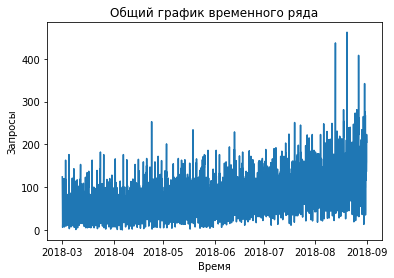

In [9]:
# посмотрим на график временного ряда
plt.title('Общий график временного ряда')
plt.xlabel('Время')
plt.ylabel('Запросы')

plt.plot(df)
plt.show()


На графике очень много колебаний, ничего не понятно, надо сделать его более информативным. Тут видны в том числе и выделяющиеся значения, рассмотри их более детально.

<AxesSubplot:>

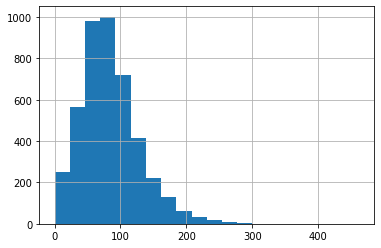

In [10]:
df['num_orders'].hist(bins=20)

Итак, возвращаемся в временному ряду. Для снижения "колебательности" используем технику скользящего среднего.

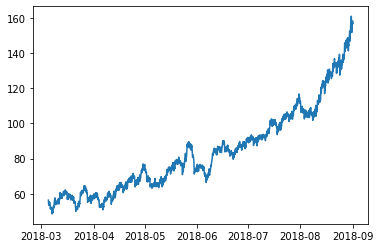

In [11]:

df_rm = df.rolling(100).mean()
plt.plot(df_rm)

В таком виде попробуем определить тренд, сезонность и шумы.

In [12]:
# для постороения графиков тренда и сезонности уберем пустые значчения, образовавщиеся после формирования скользящего окна
df.isna().sum()

num_orders    0
dtype: int64

In [13]:
df = df.dropna()

Text(0.5, 1.0, 'Season per day')

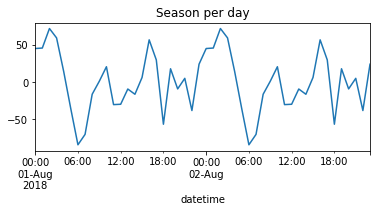

In [14]:
decomposed = seasonal_decompose(df)



decomposed = seasonal_decompose(df['2018-08-01':'2018-08-02'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Season per day')

  

Text(0.5, 1.0, 'Season per week')

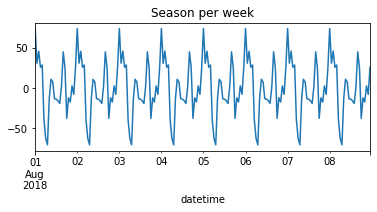

In [15]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-08'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Season per week')


Text(0.5, 1.0, 'Trend')

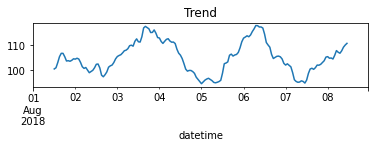

In [16]:
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')



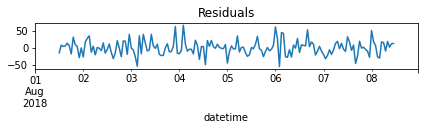

In [17]:
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Выводы:
    1.Сезонность в суточном масштабе выражается в росте количества заказов с 6 до 11 утра. Пик приходится до 12. Далее следует рост примерно до 17 часов и падение к 18 часам. С 18 до полуночи спрос снова растет. 
    2. Сезонность в недельном мастабе выражается в повторении суточных изменений.
    3. Тренд показывает, что в целом количество заказов растет.

## Обучение

##### Добавим признаков

In [18]:
# Добавим признаков с помощью функции:

def make_features(data, max_lag, rolling_mean_size):
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data


In [19]:
# Параметры признаков можно будет поменять, если что 

make_features(df, 24, 10).head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Разделим датасет на выборки

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

In [21]:
# проверим их по форме 
# добавим тестовую выборку

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, shuffle=False, test_size=0.5)

print(features_train.shape)
print(target_train.shape)
print()
print(features_valid.shape)
print(target_valid.shape)
print()
print(features_test.shape)
print(target_test.shape)

(3508, 27)
(3508,)

(442, 27)
(442,)

(442, 27)
(442,)


### Обучение моделей

#### Линейная регрессия

In [22]:
model = LinearRegression()
model.fit(features_train, target_train)
preds = model.predict(features_valid)

RMSE = mean_squared_error(target_valid, preds)**0.5

print('RMSE модели линейной регрессии:', RMSE )

RMSE модели линейной регрессии: 34.31096147942389


#### Решающее дерево

In [23]:
# Подготовим данные для кросс валидации с особенностями временного ряда

tscv = TimeSeriesSplit(n_splits=5)

In [24]:
model_rf = RandomForestRegressor(random_state=1)

params = {'max_depth' : [4,6,8, 10],
          'n_estimators' : range(10,40,2)}

grid_CV = GridSearchCV(estimator=model_rf, 
                         param_grid=params, 
                         scoring = 'neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1,
                         return_train_score=True)

grid_CV.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'n_estimators': range(10, 40, 2)},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [25]:
best_params = grid_CV.best_params_
print(best_params)
print()
best_score = grid_CV.best_score_
print('Оценка лучшей модели случайного леса на кросс-валидации', -(best_score))

{'max_depth': 10, 'n_estimators': 38}

Оценка лучшей модели случайного леса на кросс-валидации 24.437857585422265


#### Градиентный бустинг

In [26]:
# обучение
model_gb = CatBoostRegressor(iterations = 10000, learning_rate = 0.03)

model_gb.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=False, use_best_model = True)

print('Params')
print(model_gb.get_params())

Params
{'iterations': 10000, 'learning_rate': 0.03, 'loss_function': 'RMSE'}


In [27]:
# предсказание

print( 'RMSE для катбуста', model_gb.get_best_score())


RMSE для катбуста {'learn': {'RMSE': 0.7664892298207434}, 'validation': {'RMSE': 30.721126359934747}}


#### выводы:

    Среди выбранных моделей (линейная регрессия, случайный лес и градиентный бустинг) минимальную ошибку показала модель случайного леса на кросс_валидации. Ее и выберем для окончательного тестирования

### Тестирование

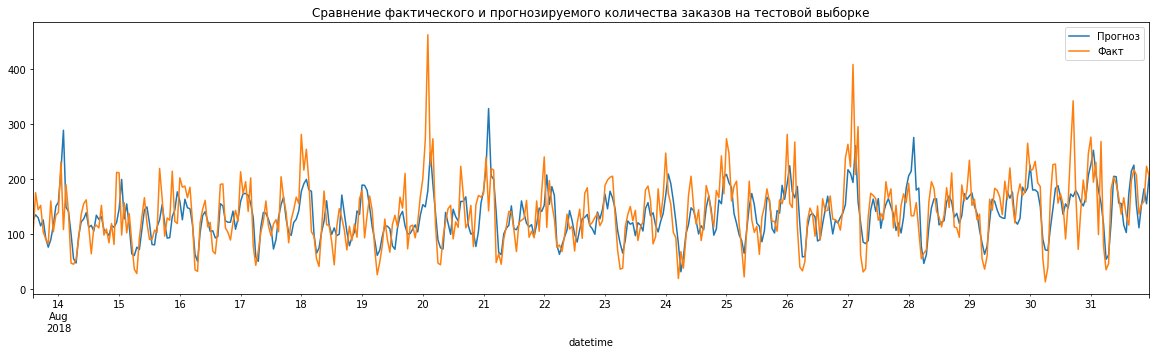


RMSE на тестовой выборке 45.61656305134902


In [28]:
predictions = model.predict(features_test)

pd.DataFrame({'Прогноз':predictions,
                 'Факт':target_test}).plot(figsize=(20, 5))
plt.title('Сравнение фактического и прогнозируемого количества заказов на тестовой выборке')
plt.show()
print()

print('RMSE на тестовой выборке',mean_squared_error(predictions, target_test)**0.5)

#print('Реальное количество заказов в последний час:', target_test.values[-1])
#print('Предсказанное количество заказов в последний час:', predictions[-1])



### Выводы:

    На этапе подготовки данных мы:
        сменили тип данных для времени
        изменили индекс таблицы для дальнейшего удобства
        проверили хронологию индексов
        удалили пропуски
    
    На этапе анализа:
        провели ресемплинг
        сгладили график "скользящим окном"
        добавили признаков

    На этапе пердсказания проверили три модели обучения для повышения качества предсказаний модели мы использовали перебор гиперпараметров и кросс валидацию для временного ряда. Несмотря на высокие результаты на обучающей выборке у модели случайного леса, на тестовой выборке лучше всех себя показала линейная регрессия.
    
    Нам удалось провести анализ временного ряда для создаия модели, которая дает достаточно точные предсказания в рамках ТЗ.